### Parametry do optymalizacji:
- minimalna powierzchnia *min_size*,
- minimalny dystans między polygonami *cluster_max_dist*,
- dodatkowe filtrowanie klastrów *min_polygon_num*, *min_size* (po liczbie polygonów i ich polu),
- concave (wtedy jaki parametr, chyba można dla każdego liczyć parametr, aż pole hull będzie niemniejsze niż suma pól polygonów), convex czy jeszcze coś innego,

### Inne
- w którychś momentach trzeba odjąć zakazane i dodać margines

In [1]:
import json
import cv2
import numpy as np
import os
from shapely.geometry import Polygon, MultiPolygon
from collections import deque
import matplotlib.pyplot as plt

In [2]:
def bfs_split_mask(mask):
    rows, cols, *_ = mask.shape
    binary_mask = np.zeros((rows, cols))
    binary_mask[mask[:, :, 3] > 0] = 1
    visited = np.zeros_like(binary_mask, dtype=bool)
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    regions = []

    for r in range(rows):
        for c in range(cols):
            if binary_mask[r, c] == 1 and not visited[r, c]:
                region = np.zeros_like(binary_mask, dtype=np.uint8)
                queue = deque([(r, c)])
                visited[r, c] = True

                while queue:
                    x, y = queue.popleft()
                    region[x, y] = 1

                    for dx, dy in directions:
                        nx, ny = x + dx, y + dy
                        if 0 <= nx < rows and 0 <= ny < cols and binary_mask[nx, ny] == 1 and not visited[nx, ny]:
                            queue.append((nx, ny))
                            visited[nx, ny] = True

                regions.append(region)

    return regions

def regions_to_polygons(regions):
    polygons = []
    for region in regions:
        contours, _ = cv2.findContours(region, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        for contour in contours:
            coords = [(point[0][0], point[0][1]) for point in contour]

            if len(coords) < 3:
                continue

            polygon = Polygon(coords)

            if polygon.is_valid and polygon.area > 0:
                polygons.append(polygon)
            elif polygon.buffer(0).is_valid:
                polygon = polygon.buffer(0)
                if isinstance(polygon, MultiPolygon):
                    for polygon_split in list(polygon.geoms):
                        polygons.append(polygon_split)
                else:
                    polygons.append(polygon.buffer(0))

    return polygons

### Load homography info

In [28]:
info_path = r'C:\Users\gtraw\OneDrive\Pulpit\UM sem. 2\ProjektBadawczy\apps\image_processing\homography_info'
with open(os.path.join(info_path, 'info.json'), 'r') as info_file:
    homography_info = json.load(info_file)

H1 = np.load(os.path.join(info_path, homography_info['cameras']['weti1']['filename']))
H2 = np.load(os.path.join(info_path, homography_info['cameras']['weti2']['filename']))
H12 = np.load(os.path.join(info_path, homography_info['cameras']['weti1_weti2']['filename']))

homography = {
    'weti1': H1,
    'weti2': H2,
    'weti1_weti2': H12
}

### Load masks

In [4]:
camera_ids = ['weti1', 'weti2']
# loading masks
camera_masks = {
    cid: {
        'allowed': cv2.imread(os.path.join(info_path, f"allowed_{cid}.png"), cv2.IMREAD_UNCHANGED),
        'forbidden': cv2.imread(os.path.join(info_path, f"forbidden_{cid}.png"), cv2.IMREAD_UNCHANGED)
    } for cid in camera_ids
}

# crop to top left corner
for cid in camera_ids:
    offx, offy = homography_info['cameras'][cid]['offset']
    camera_masks[cid]['allowed'] = camera_masks[cid]['allowed'][offy:, offx:]
    camera_masks[cid]['forbidden'] = camera_masks[cid]['forbidden'][offy:, offx:]

### Transform masks to polygons

In [90]:
def transform_point(point, H):
    point = np.array([*point, 1])
    transformed_point = np.dot(H, point)
    transformed_point /= transformed_point[2]
    return transformed_point[:2]

def transform_polygon(polygon, H, scale=1):
    transformed_points = [transform_point(p, H) * scale for p in np.array(polygon.exterior.coords)]
    return Polygon(transformed_points)

def filter_polygons(polygons: list[Polygon], min_size=5):
    return [p for p in polygons if p.area > min_size]

In [91]:
# masks to separate regions
camera_polygons = {
    cid: {
        'allowed': regions_to_polygons(bfs_split_mask(camera_masks[cid]['allowed'])),
        'forbidden': regions_to_polygons(bfs_split_mask(camera_masks[cid]['forbidden']))
    } for cid in camera_ids
}

In [101]:
# regions to polygons with area filter
camera_polygons_transformed = {
    cid: {
        'allowed': filter_polygons([transform_polygon(poly, homography[cid]) for poly in camera_polygons[cid]['allowed']], min_size=8),
        'forbidden': filter_polygons([transform_polygon(poly, homography[cid]) for poly in camera_polygons[cid]['forbidden']], min_size=8)
    } for cid in camera_ids
}

In [99]:
# merging two cameras
# weti1 to weti2
cid = 'weti1'
hid = 'weti1_weti2'
camera_polygons_transformed[cid] = {
    'allowed': [transform_polygon(poly, homography[hid]) for poly in camera_polygons_transformed[cid]['allowed']],
    'forbidden': [transform_polygon(poly, homography[hid]) for poly in camera_polygons_transformed[cid]['forbidden']]
}

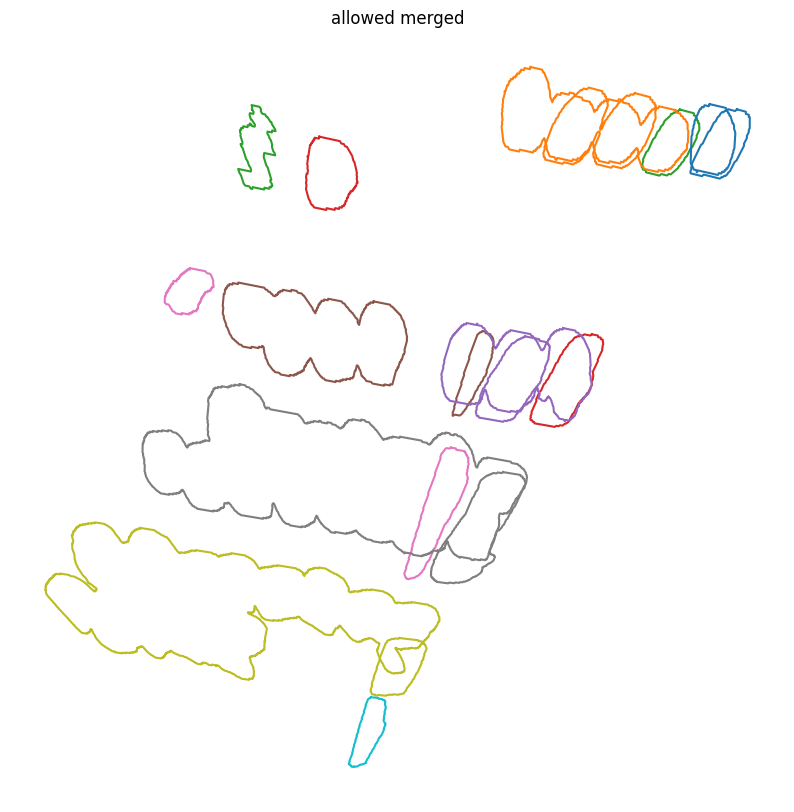

In [102]:
fig, ax = plt.subplots(figsize=(10, 10))

for poly in camera_polygons_transformed['weti1']['allowed']:
    ax.plot(*poly.exterior.xy)
for poly in camera_polygons_transformed['weti2']['allowed']:
    ax.plot(*poly.exterior.xy)

ax.set_title("Separate Regions")
plt.axis("off")
plt.title('allowed merged')
plt.show()

40.523364543631125
364.1752254308085
85.07052561517504
104.91137325484368
45.89782811466552
724.7354868622637
70.22800931773698
42.308425001013276
30.490034245088314


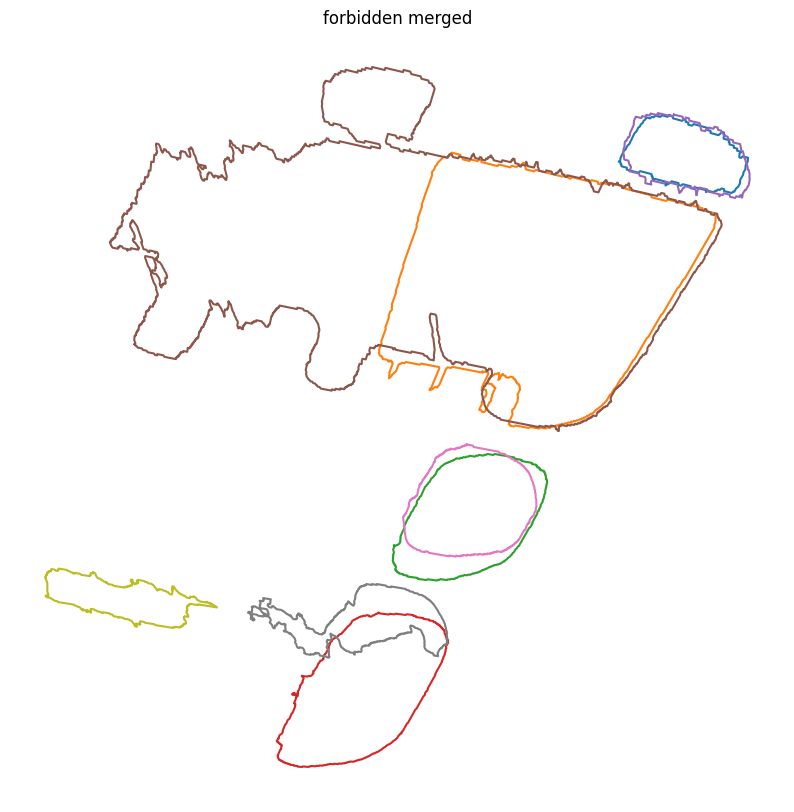

In [103]:
area_f_threshold = 1
fig, ax = plt.subplots(figsize=(10, 10))

for poly in camera_polygons_transformed['weti1']['forbidden']:
    print(poly.area)
    if poly.area > area_f_threshold:
        ax.plot(*poly.exterior.xy)
for poly in camera_polygons_transformed['weti2']['forbidden']:
    print(poly.area)
    if poly.area > area_f_threshold:
        ax.plot(*poly.exterior.xy)

ax.set_title("Separate Regions")
plt.axis("off")
plt.title('forbidden merged')
plt.show()

### Allowed polygons to clusters

In [114]:
from sklearn.cluster import DBSCAN

def polygon_distance_matrix(polygons):
    n = len(polygons)
    dist_matrix = np.zeros((n, n))
    for i in range(n):
        for j in range(i + 1, n):
            dist = polygons[i].distance(polygons[j])
            dist_matrix[i, j] = dist
            dist_matrix[j, i] = dist
    return dist_matrix

In [117]:
cluster_max_dist = 0.5 
all_allowed_polygons = sum([camera_polygons_transformed[cid]['allowed'] for cid in camera_polygons_transformed], [])

distance_matrix = polygon_distance_matrix(all_allowed_polygons)

dbscan = DBSCAN(eps=cluster_max_dist, min_samples=1, metric="precomputed")
labels = dbscan.fit_predict(distance_matrix)
clustered_polygons = [[all_allowed_polygons[i] for i in range(len(all_allowed_polygons)) if labels[i] == cluster_id] for cluster_id in set(labels)]

for i, cluster in enumerate(clustered_polygons):
    print(f"cluster {i+1}. {[list(poly.exterior.coords) for poly in cluster]}")

cluster 1. [[(36.2031313386826, 58.00212653326952), (36.09493740791118, 57.82196993569398), (35.71202537236572, 58.019680644405696), (35.60426631381556, 57.839362879408625), (35.54947832164828, 57.86758939622599), (35.44197703974388, 57.68757600113228), (35.38718970685539, 57.71573996013804), (35.279945518724304, 57.53603019566474), (35.22765608792739, 57.32869058606796), (35.12083497894884, 57.14981615634714), (35.01706002682094, 56.73768079478375), (34.91085352661607, 56.56008623870036), (34.70570414729581, 55.74407207166364), (34.60048886497844, 55.56862932192113), (34.297889404653155, 54.363102222149294), (34.19402277476798, 54.19063445937636), (33.70184530214085, 52.22676288439883), (33.70659017335598, 52.00742304599762), (33.65813153794586, 51.81436851066547), (33.66292985664942, 51.59627207827074), (33.61466215927087, 51.40427966278479), (33.619513255109446, 51.18741618612165), (34.25338012649383, 50.88411473470363), (34.354940103334926, 51.049301653339846), (35.246832794068716,

In [118]:
clustered_polygons[0]

[<POLYGON ((36.203 58.002, 36.095 57.822, 35.712 58.02, 35.604 57.839, 35.549...>,
 <POLYGON ((30.528 59.734, 30.423 59.549, 30.309 59.607, 30.205 59.422, 30.09...>,
 <POLYGON ((33.028 57.983, 32.923 57.803, 32.867 57.831, 32.762 57.65, 32.706...>,
 <POLYGON ((34.685 58.559, 34.632 58.334, 34.396 58.44, 34.343 58.214, 34.249...>,
 <POLYGON ((24.738 62.515, 24.7 62.278, 24.404 62.411, 24.367 62.174, 24.219 ...>]

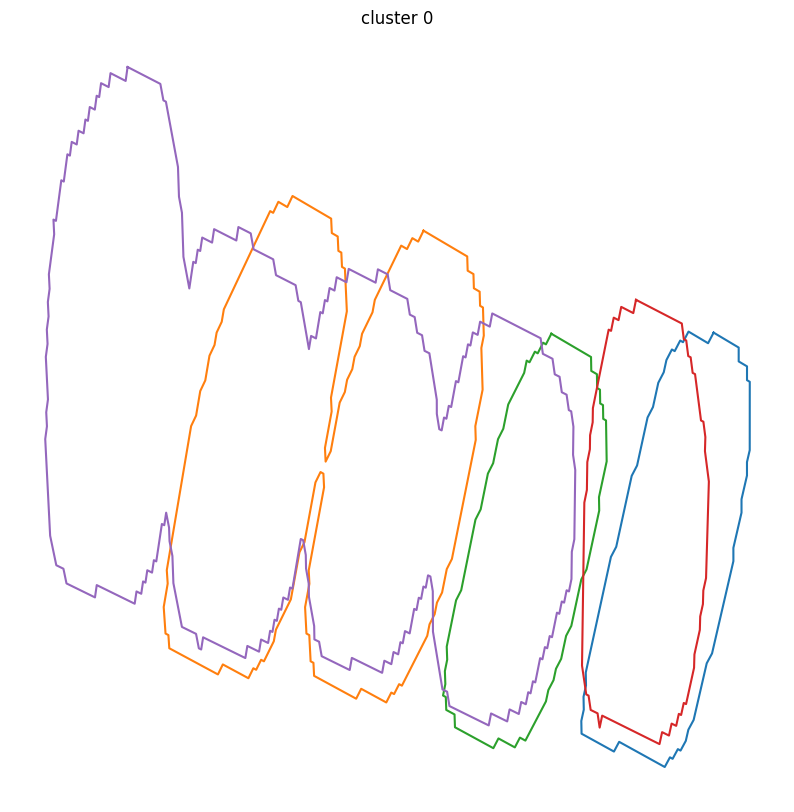

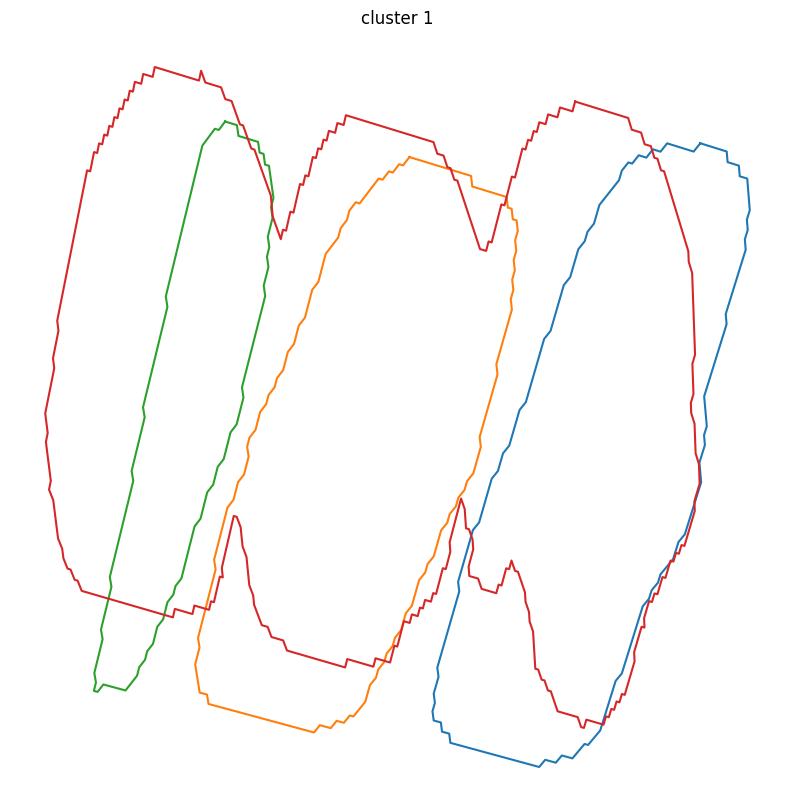

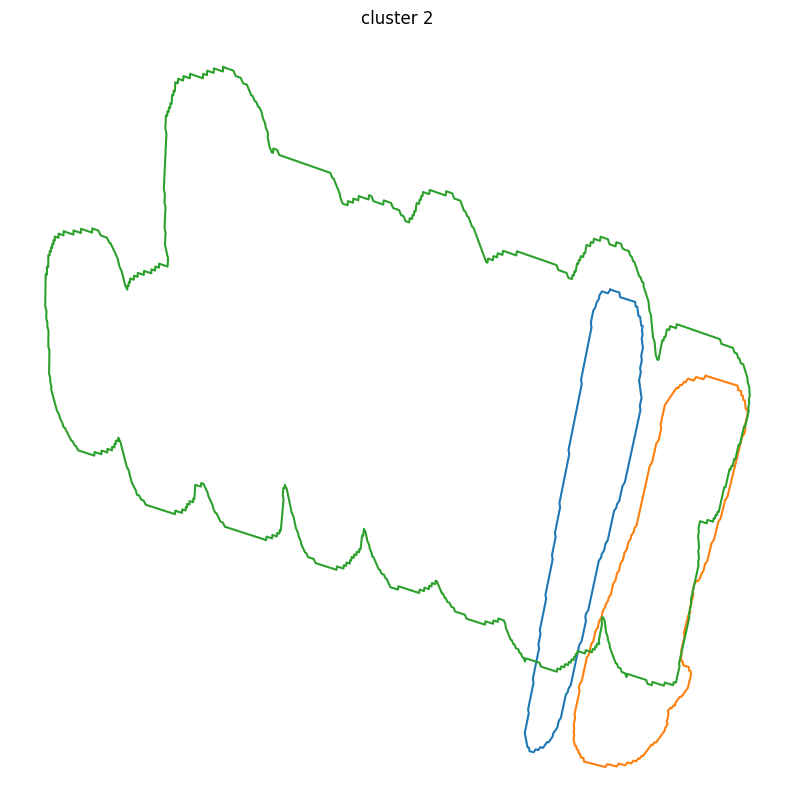

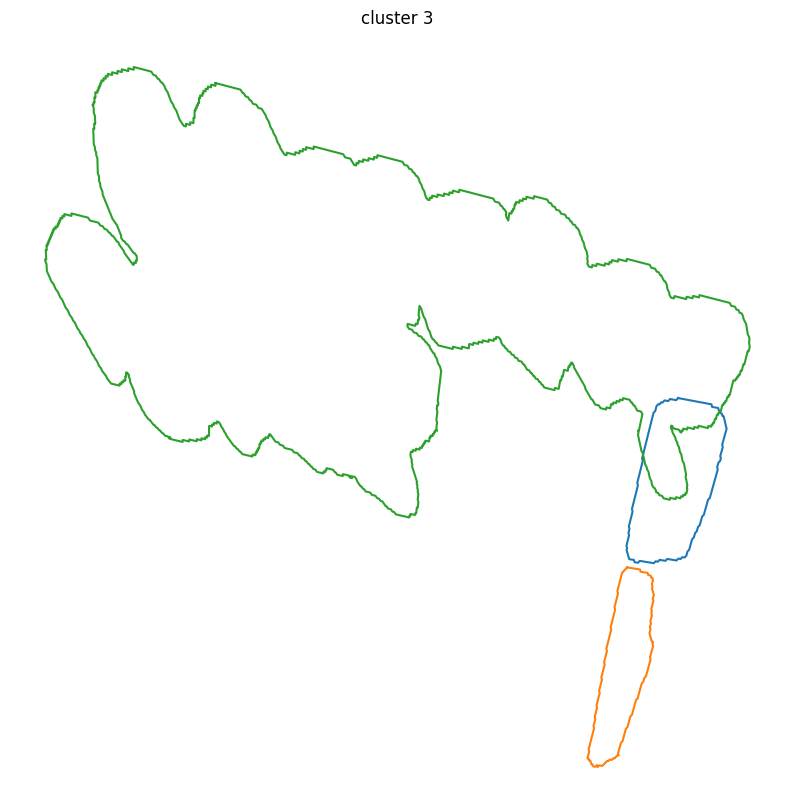

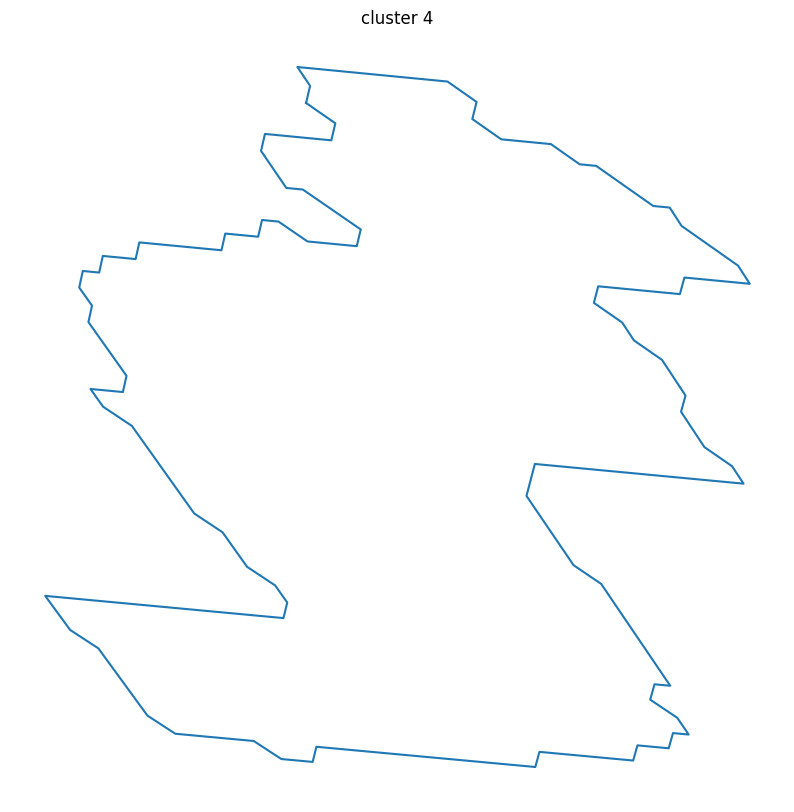

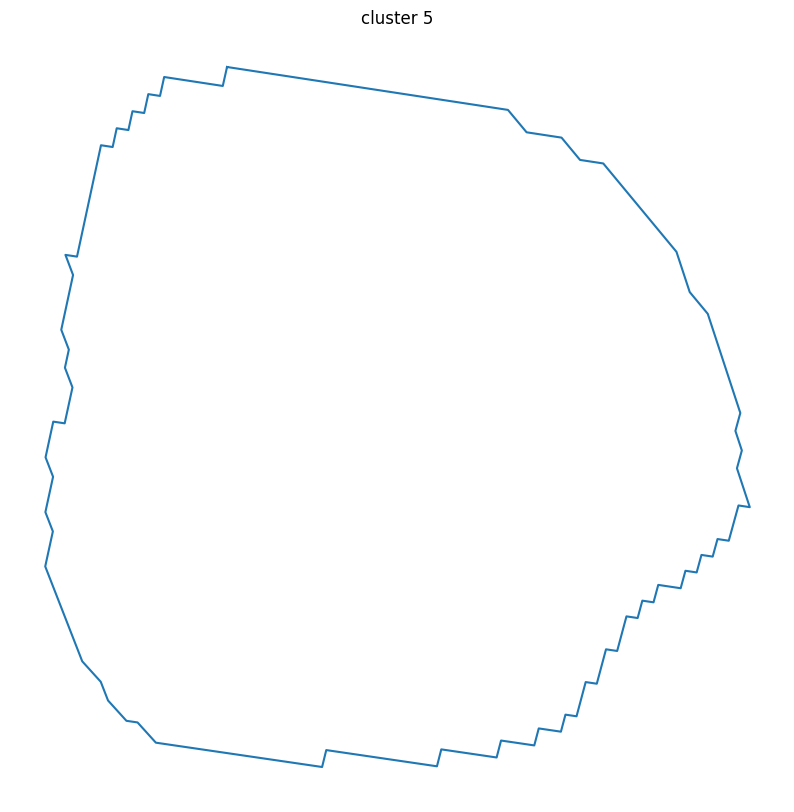

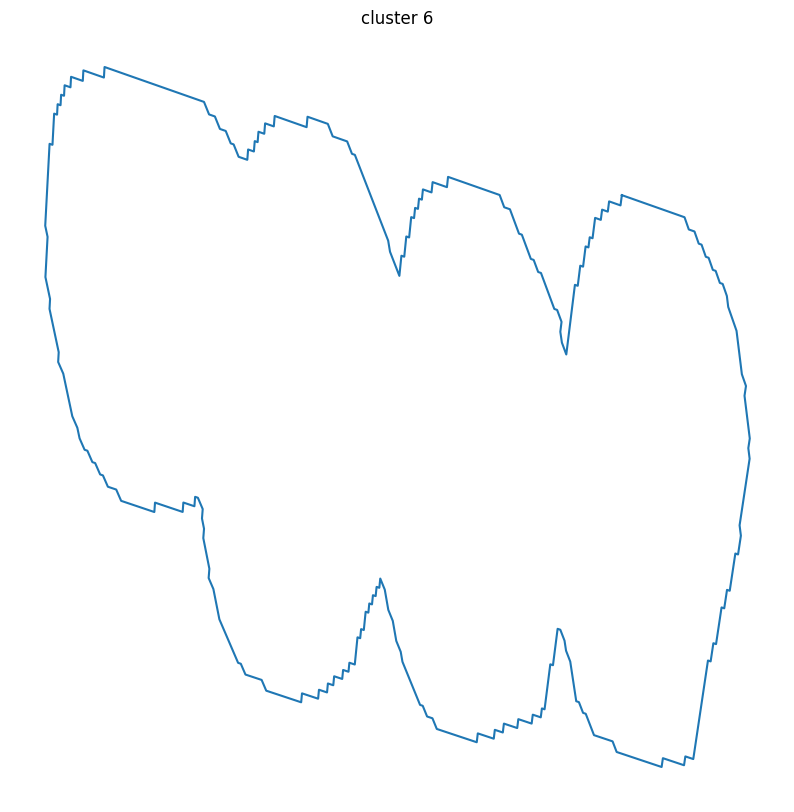

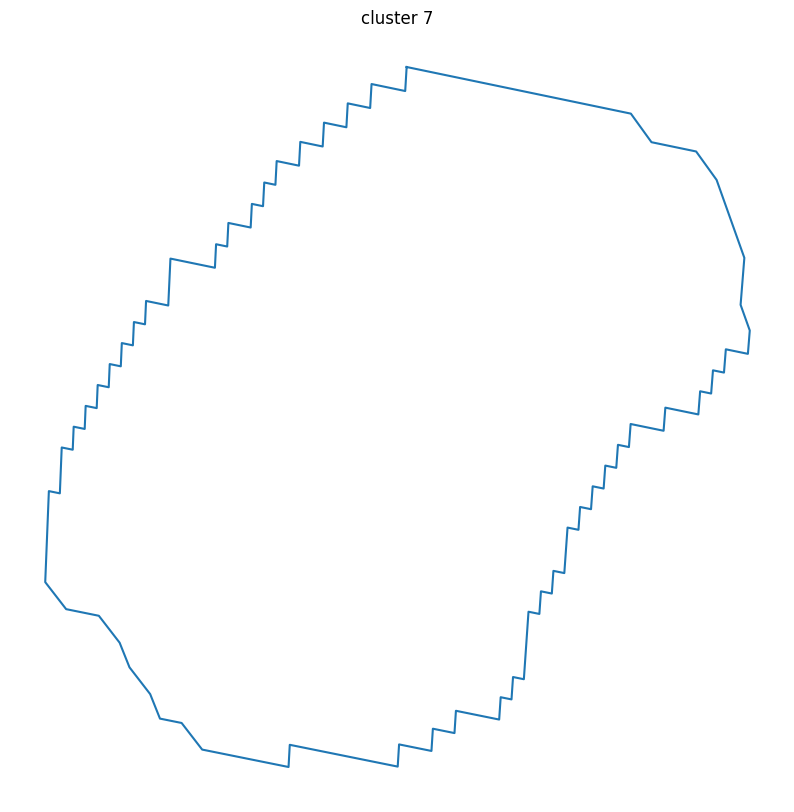

In [144]:
for cluster_id, cluster in enumerate(clustered_polygons):
    area_f_threshold = 1
    fig, ax = plt.subplots(figsize=(10, 10))

    for poly in cluster:
        ax.plot(*poly.exterior.xy)

    ax.set_title("Separate Regions")
    plt.axis("off")
    plt.title(f'cluster {cluster_id}')
    plt.show()

### Merging allowed

In [194]:
from shapely import GeometryCollection, MultiPolygon, concave_hull

def merge_clusters(clustered_polygons, mode='convex', hull_param=0.5):
    merged_clusters = []
    for cluster in clustered_polygons:
        print("cluster size:", len(cluster))
        collection = GeometryCollection(cluster)
        if mode == 'concave':
            merged_clusters.append(concave_hull(collection, hull_param))
        elif mode == 'convex':
            merged_clusters.append(collection.convex_hull)
    return merged_clusters

def filter_clusters(clustered_polygons, min_polygon_num=0, min_size=0):
    return [cp for cp in clustered_polygons if len(cp) >= min_polygon_num or MultiPolygon(cp).area >= min_size]

cluster size: 5
cluster size: 4
cluster size: 3
cluster size: 3
cluster size: 1
cluster size: 1
cluster size: 1
cluster size: 1


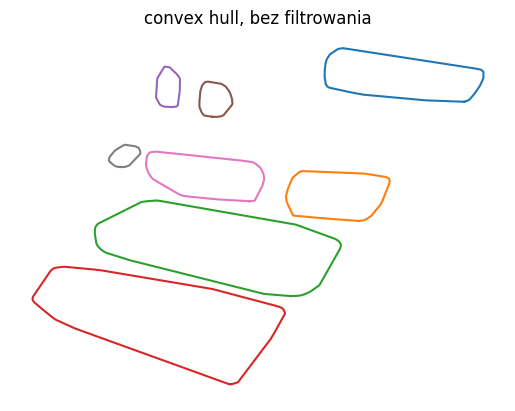

In [199]:
merged_clusters = merge_clusters(filter_clusters(clustered_polygons))

for poly in merged_clusters:
    plt.plot(*poly.exterior.xy)

# for poly in camera_polygons_transformed['weti1']['allowed']:
#     plt.plot(*poly.exterior.xy)
# for poly in camera_polygons_transformed['weti2']['allowed']:
#     plt.plot(*poly.exterior.xy)

plt.axis("off")
plt.title(f'convex hull, bez filtrowania')
plt.show()

cluster size: 5
cluster size: 4
cluster size: 3
cluster size: 3
cluster size: 1
cluster size: 1


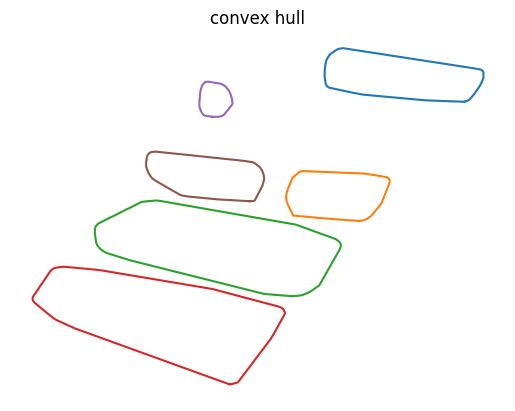

In [204]:
merged_clusters = merge_clusters(filter_clusters(clustered_polygons, 2, 12))

for poly in merged_clusters:
    plt.plot(*poly.exterior.xy)

# for poly in camera_polygons_transformed['weti1']['allowed']:
#     plt.plot(*poly.exterior.xy)
# for poly in camera_polygons_transformed['weti2']['allowed']:
#     plt.plot(*poly.exterior.xy)

plt.axis("off")
plt.title(f'convex hull')
plt.show()

cluster size: 5
cluster size: 4
cluster size: 3
cluster size: 3
cluster size: 1
cluster size: 1


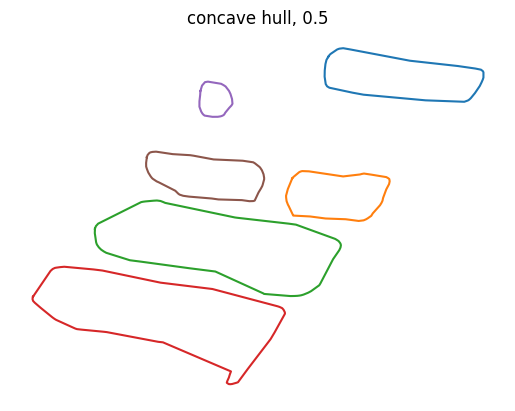

In [201]:
merged_clusters = merge_clusters(filter_clusters(clustered_polygons, 2, 12), 'concave')

for poly in merged_clusters:
    plt.plot(*poly.exterior.xy)

# for poly in camera_polygons_transformed['weti1']['allowed']:
#     plt.plot(*poly.exterior.xy)
# for poly in camera_polygons_transformed['weti2']['allowed']:
#     plt.plot(*poly.exterior.xy)

plt.axis("off")
plt.title(f'concave hull, 0.5')
plt.show()